<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
<br>
<font size = 4><b>Специализация "Машинное обучение и анализ данных"</b></font>
</center>
<br>
<center>
<font size = 3>Дипломный проект</font>
</center>
<center>
<font size = 3><b>Идентификация интернет-пользователей по повещенным веб-страницам</b></font>
</center>
<center>
Автор: Игорь Демидов
</center>

# <center> Описание задачи

В этом проекте решается задача идентификации пользователя по его поведению в сети Интернет: по последовательности из нескольких веб-сайтов, посещенных подряд одим и тем же человеком, мы будем идентифицировать этого человека. Идея такая: пользователи Интернета по-разному переходят по ссылкам, и это может помогать их идентифицировать (кто-то сначала в почту, потом про футбол почитать, затем новости, контакт, потом наконец – работать, кто-то – сразу работать).

Имеются данные с прокси-серверов Университета Блеза Паскаля, они имеют очень простой вид. Для каждого пользователя заведен csv-файл с названием user\*\*\*\*.csv (где вместо звездочек – 4 цифры, соответствующие ID пользователя), а в нем посещения сайтов записаны в следующем формате: <br>

<center>*timestamp, посещенный веб-сайт*</center>

В этом проекте придется столкнуться с тем, что не все операции можно выполнить за разумное время (скажем, перебрать с кросс-валидацией 100 комбинаций параметров случайного леса), поэтому мы будем использовать параллельно 2 выборки: по 10 пользователям и по 150. Для 10 пользователей будем писать и отлаживать код, для 150 – будет рабочая версия. 

Данные устроены следующем образом:

 - В каталоге 10users лежат 10 csv-файлов с названием вида "user[USER_ID].csv", где [USER_ID] – ID пользователя;
 - Аналогично для каталога 150users – там 150 файлов;
 - В каталоге 3users – игрушечный пример из 3 файлов, это для отладки кода предобработки.

# <center>Часть 1. Подготовка данных к анализу и построению моделей

Первая часть проекта посвящена подготовке данных для дальнейшего описательного анализа и построения прогнозных моделей.

In [1]:
# Импортируем все необходимые библиотеки

from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from scipy.sparse import csr_matrix
from statsmodels.stats.proportion import proportion_confint
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC
import datetime
% pylab inline

Populating the interactive namespace from numpy and matplotlib


**Посмотрим на один из файлов с данными о посещенных пользователем (номер 31) веб-страницах.**

In [2]:
# Локальный путь к данным
PATH_TO_DATA = ('/home/demi/Документы/Final_project/capstone_user_identification' )

In [3]:
user31_data = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                       '10users/user0031.csv'))

In [4]:
user31_data.head(10)

,timestamp,site
0,2013-11-15 08:12:07,fpdownload2.macromedia.com
1,2013-11-15 08:12:17,laposte.net
2,2013-11-15 08:12:17,www.laposte.net
3,2013-11-15 08:12:17,www.google.com
4,2013-11-15 08:12:18,www.laposte.net
5,2013-11-15 08:12:38,www.laposte.net
6,2013-11-15 08:12:39,www.google.com
7,2013-11-15 08:12:39,www.laposte.net
8,2013-11-15 08:12:40,match.rtbidder.net
9,2013-11-15 08:12:40,www.laposte.net


**Поставим задачу классификации: идентифицировать пользователя по сессии из 10 подряд посещенных сайтов. Объектом в этой задаче будет сессия из 10 сайтов, последовательно посещенных одним и тем же пользователем, признаками – индексы этих 10 сайтов. Целевым классом будет id пользователя.**

### <center>Пример для иллюстрации</center>
**Пусть пользователя всего 2, длина сессии – 2 сайта.**

<center>user0001.csv</center>
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-yw4l{vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-031e">timestamp</th>
    <th class="tg-031e">site</th>
  </tr>
  <tr>
    <td class="tg-031e">00:00:01</td>
    <td class="tg-031e">vk.com</td>
  </tr>
  <tr>
    <td class="tg-yw4l">00:00:11</td>
    <td class="tg-yw4l">google.com</td>
  </tr>
  <tr>
    <td class="tg-031e">00:00:16</td>
    <td class="tg-031e">vk.com</td>
  </tr>
  <tr>
    <td class="tg-031e">00:00:20</td>
    <td class="tg-031e">yandex.ru</td>
  </tr>
</table>

<center>user0002.csv</center>
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-yw4l{vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-031e">timestamp</th>
    <th class="tg-031e">site</th>
  </tr>
  <tr>
    <td class="tg-031e">00:00:02</td>
    <td class="tg-031e">yandex.ru</td>
  </tr>
  <tr>
    <td class="tg-yw4l">00:00:14</td>
    <td class="tg-yw4l">google.com</td>
  </tr>
  <tr>
    <td class="tg-031e">00:00:17</td>
    <td class="tg-031e">facebook.com</td>
  </tr>
  <tr>
    <td class="tg-031e">00:00:25</td>
    <td class="tg-031e">yandex.ru</td>
  </tr>
</table>

Идем по 1 файлу, нумеруем сайты подряд: vk.com – 1, google.com – 2 и т.д. Далее по второму файлу. 

Отображение сайтов в их индесы должно получиться таким:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-yw4l{vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-031e">site</th>
    <th class="tg-yw4l">site_id</th>
  </tr>
  <tr>
    <td class="tg-yw4l">vk.com</td>
    <td class="tg-yw4l">1</td>
  </tr>
  <tr>
    <td class="tg-yw4l">google.com</td>
    <td class="tg-yw4l">2</td>
  </tr>
  <tr>
    <td class="tg-yw4l">yandex.ru</td>
    <td class="tg-yw4l">3</td>
  </tr>
  <tr>
    <td class="tg-yw4l">facebook.com</td>
    <td class="tg-yw4l">4</td>
  </tr>
</table>

Тогда обучающая выборка будет такой (целевой признак – user_id):
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-s6z2{text-align:center}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-hgcj{font-weight:bold;text-align:center}
.tg .tg-amwm{font-weight:bold;text-align:center;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-hgcj">session_id</th>
    <th class="tg-hgcj">site1</th>
    <th class="tg-hgcj">site2</th>
    <th class="tg-amwm">user_id</th>
  </tr>
  <tr>
    <td class="tg-s6z2">1</td>
    <td class="tg-s6z2">1</td>
    <td class="tg-s6z2">2</td>
    <td class="tg-baqh">1</td>
  </tr>
  <tr>
    <td class="tg-s6z2">2</td>
    <td class="tg-s6z2">1</td>
    <td class="tg-s6z2">3</td>
    <td class="tg-baqh">1</td>
  </tr>
  <tr>
    <td class="tg-s6z2">3</td>
    <td class="tg-s6z2">3</td>
    <td class="tg-s6z2">2</td>
    <td class="tg-baqh">2</td>
  </tr>
  <tr>
    <td class="tg-s6z2">4</td>
    <td class="tg-s6z2">4</td>
    <td class="tg-s6z2">3</td>
    <td class="tg-baqh">2</td>
  </tr>
</table>

Здесь 1 объект – это сессия из 2 посещенных сайтов 1-ым пользователем (target=1). Это сайты vk.com и google.com (номер 1 и 2). И так далее, всего 4 сессии. Пока сессии у нас не пересекаются по сайтам, то есть посещение каждого отдельного сайта относится только к одной сессии.

## Часть 1.1. Подготовка обучающей выборки
Функция *prepare_train_set* принимает на вход путь к каталогу с csv-файлами *path_to_csv_files* и параметр *session_length* – длину сессии, а возвращает 2 объекта:
- DataFrame, в котором строки соответствуют уникальным сессиям из *session_length* сайтов, *session_length* столбцов – индексам этих *session_length* сайтов и последний столбец – ID пользователя
- частотный словарь сайтов вида {'site_string': [site_id, site_freq]}, например для недавнего игрушечного примера это будет {'vk.com': (1, 2), 'google.com': (2, 2), 'yandex.ru': (3, 3), 'facebook.com': (4, 1)}

Комментарии:
- Меньшие индексы даются более часто попадающимся сайтам (приницип наименьшего описания)
- Скорее всего в файле число записей не кратно числу *session_length*. Тогда последняя сессия будет короче. Остаток заполняем нулями. То есть если в файле 24 записи и сессии длины 10, то 3 сессия будет состоять из 4 сайтов, и ей мы сопоставим вектор [*site1_id*, *site2_id*, *site3_id*, *site4_id*, 0, 0, 0, 0, 0, 0, *user_id*] 
- В итоге некоторые сессии могут повторяться – оставляем как есть, не удаляя дубликаты. Если в двух сессиях все сайты одинаковы, но сессии принадлежат разным пользователям, то тоже оставляем как есть, это естественная неопределенность в данных

In [5]:
def prepare_train_set(path_to_csv_files, session_length=10):
    # Создание словаря сайтов
    a = {}
    for j in xrange(len(path_to_csv_files)):
        data_sort = list(pd.read_csv(path_to_csv_files[j], squeeze = True, usecols=['site']))
        for i in xrange(len(data_sort)):
            a[data_sort[i]] = a.get(data_sort[i], 0) + 1
    
    # Упорядочиваем индексы в словаре сайтов по популярности сайта
    b = sorted(a.items(), key = lambda x: x[1], reverse = True)
    b1 = {}
    id = 1
    for i in range(len(b)):
        b1[b[i][0]] = (id, b[i][1])
        id += 1
    
    b2 = sorted(b1.items(), key = lambda x: x[1][1], reverse = True)
    
    b4 = dict(b2)
    
    b3 = pd.DataFrame(data = b2, columns=(['site', 'freq']))

    # Создаем новый датафрейм для матрицы пользователи-сайты
    df_list = list(["site%s" % k for k in range(1, session_length + 1)])
    df_list.append('user_id')
    dataframe_list = []

    # Преобразуем информацию о посещенных сайтах в необходимый формат, используя словарь частот сайтов
    for i in range(len(path_to_csv_files)):
        data = list(pd.read_csv(path_to_csv_files[i], squeeze = True, usecols=['site']))
        if (len(data) % session_length) != 0:
            n = (len(data) // session_length) + 1
        else:
            n = len(data) // session_length
        for j in range(n):
            new_line = []
            new_line = list(b4[data[session_length * j + k]][0] if (
                j * session_length + k) < len(data) else 0 for k in range(session_length))
            new_line.append(i + 1)
            dataframe_list.append(new_line)
    c = pd.DataFrame(data = dataframe_list, columns=df_list)
    
    return c, b2

In [6]:
user_path3 = glob(os.path.join(PATH_TO_DATA, '3users/*.csv'))
user_path10 = glob(os.path.join(PATH_TO_DATA, '10users/*.csv'))
user_path150 = glob(os.path.join(PATH_TO_DATA, '150users/*.csv'))

In [7]:
# Отсортируем файлы по номеру пользователя
user_path10.sort()
user_path150.sort()
user_path3.sort()

**Применим полученную функцию к игрушечному примеру, чтобы убедиться, что все работает как надо.**

In [8]:
train_data_toy, site_freq_3users = prepare_train_set(user_path3, 
                                                     session_length=10)

In [9]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id
0,4,2,2,11,2,1,8,5,9,7,1
1,4,1,1,1,0,0,0,0,0,0,1
2,4,2,6,6,2,0,0,0,0,0,2
3,3,1,2,1,2,1,1,5,10,3,3
4,3,1,2,0,0,0,0,0,0,0,3


Частоты сайтов (второй элемент кортежа) точно должны быть такими, нумерация может быть любой (первые элементы кортежей могут отличаться).

In [10]:
site_freq_3users

[('google.com', (1, 9)),
 ('oracle.com', (2, 8)),
 ('meduza.io', (3, 3)),
 ('vk.com', (4, 3)),
 ('mail.google.com', (5, 2)),
 ('football.kulichki.ru', (6, 2)),
 ('plus.google.com', (7, 1)),
 ('accounts.google.com', (8, 1)),
 ('apis.google.com', (9, 1)),
 ('yandex.ru', (10, 1)),
 ('geo.mozilla.org', (11, 1))]

**Применим полученную функцию к данным по 10 пользователям и посмотрим на количество уникальных сайтов**

In [11]:
train_data_10users, site_freq_10users = prepare_train_set(user_path10, session_length=10)

In [12]:
print ("Количество уникальных сайтов в данных по 10 пользователям %s" % len(site_freq_10users))

Количество уникальных сайтов в данных по 10 пользователям 4913


**Применим полученную функцию к данным по 150 пользователям и посмотрим на количество уникальных сайтов**

In [13]:
%%time
train_data_150users, site_freq_150users = prepare_train_set(user_path150, session_length=10)

CPU times: user 2.59 s, sys: 48 ms, total: 2.64 s
Wall time: 2.63 s


In [14]:
print ("Количество уникальных сайтов в данных по 150 пользователям %s" % len(site_freq_150users))

Количество уникальных сайтов в данных по 150 пользователям 27797


**Топ-10 самых популярных сайтов среди посещенных 150 пользователями**

In [15]:
print ('\n'.join(site_freq_150users[i][0] for i in range(10)))

www.google.fr
www.google.com
www.facebook.com
apis.google.com
s.youtube.com
clients1.google.com
mail.google.com
plus.google.com
safebrowsing-cache.google.com
www.youtube.com


**Для дальнейшего анализа запишем полученные объекты DataFrame в csv-файлы.**

In [16]:
train_data_10users.to_csv(os.path.join(PATH_TO_DATA, 
                                       'train_data_10users.csv'), 
                        index_label='session_id', float_format='%d')
train_data_150users.to_csv(os.path.join(PATH_TO_DATA, 
                                        'train_data_150users.csv'), 
                         index_label='session_id', float_format='%d')

## Часть 1.2. Работа с разреженным форматом данных

Полученные признаки *site1*, ..., *site10* смысла не имеют как признаки в задаче классификации. А вот если воспользоваться идеей мешка слов из анализа текстов – это другое дело. Создадим новые матрицы, в которых строкам будут соответствовать сессии из 10 сайтов, а столбцам – индексы сайтов. На пересечении строки $i$ и столбца $j$ будет стоять число $n_{ij}$ – cколько раз сайт $j$ встретился в сессии номер $i$.

В коротких сессиях, меньше 10 сайтов, у остались нули, так что первый признак (сколько раз попался 0) по смыслу отличен от остальных (сколько раз попался сайт с индексом $i$). Поэтому первый столбец разреженной матрицы удалим. 

При этом мы модифицируем функцию *prepare_train_set* так, чтобы в дальнейшем сравнить модели классификации, обученные на разных выборках – с 5, 7, 10 и 15 сайтами в сессии. Более того, пока мы брали по 10 сайтов подряд, без пересечения. Теперь применим идею скользящего окна – сессии будут перекрываться. 

**Пример**: для длины сессии 10 и ширины окна 7 файл из 30 записей породит не 3 сессии, как раньше (1-10, 11-20, 21-30), а 5 (1-10, 8-17, 15-24, 22-30, 29-30). При этом в предпоследней сессии будет один ноль, а в последней – 8 нолей.

Создадим несколько выборок для разных сочетаний параметров длины сессии и ширины окна. Все они представлены в таблице ниже:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
</style>
<table class="tg">
  <tr>
    <th class="tg-031e">session_length -&gt;<br>window_size <br></th>
    <th class="tg-031e">5</th>
    <th class="tg-031e">7</th>
    <th class="tg-031e">10</th>
    <th class="tg-031e">15</th>
  </tr>
  <tr>
    <td class="tg-031e">5</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
  </tr>
  <tr>
    <td class="tg-031e">7</td>
    <td class="tg-031e"></td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
  </tr>
  <tr>
    <td class="tg-031e">10</td>
    <td class="tg-031e"></td>
    <td class="tg-031e"></td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
  </tr>
</table>

Итого получится 18 разреженных матриц – указанные в таблице 9 сочетаний параметров формирования сессий для выборок из 10 и 150 пользователей.

In [17]:
def prepare_sparse_train_set_window(path_to_csv_files, session_length=10, window_size=10):
    
    # Создание словаря сайтов
    a = {}
    for j in xrange(len(path_to_csv_files)):
        data_sort = list(pd.read_csv(path_to_csv_files[j], squeeze = True, usecols=['site']))
        for i in xrange(len(data_sort)):
            a[data_sort[i]] = a.get(data_sort[i], 0) + 1
    
    # Упорядочиваем индексы в словаре сайтов по популярности сайта
    b = sorted(a.items(), key = lambda x: x[1], reverse = True)
    b1 = {}
    id = 1
    for i in range(len(b)):
        b1[b[i][0]] = (id, b[i][1])
        id += 1
    
    b2 = sorted(b1.items(), key = lambda x: x[1][1], reverse = True)
    
    b4 = dict(b2)
    
    b3 = pd.DataFrame(data = b2, columns=(['site', 'freq']))
        
    df_list = list(["site%s" % k for k in range(1, session_length + 1)])
    df_list.append('user_id')
    dataframe_list = []

    # Преобразуем матрицу в требуемый формат с заданными длиной сессии и шириной окна
    for i in range(len(path_to_csv_files)):
        data = list(pd.read_csv(path_to_csv_files[i], squeeze = True, usecols=['site']))
        if ((len(data) - window_size) % window_size) != 0:
            n = ((len(data) - window_size) // window_size) + 2
        else:
            n = ((len(data) - window_size) // window_size) + 1

        for j in range(n):
            new_line = []
            new_line = list(b4[data[window_size * j + k]][0] if (
                j * window_size + k) < len(data) else 0 for k in range(session_length))
            new_line.append(i + 1)
            dataframe_list.append(new_line)
    c = pd.DataFrame(data = dataframe_list, columns=df_list)
    
    # Создадим разреженную матрицу из получившейся предварительной
    X_data, y = c.iloc[:, :-1].values, c.iloc[:, -1].values
     
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    for d in X_data:
        for k in d:
            if k in vocabulary:
                vocabulary[k] += 1
                indices.append(k)
            else:
                vocabulary[k] = 1
                indices.append(k)
            data.append(1)
        indptr.append(len(indices))
    
    X1 = csr_matrix((data, indices, indptr), dtype=int)
    
    # Удалим первый столбец, соотвутствующий несуществующему нулевому сайту
    all_cols = np.arange(X1.shape[1])
    cols_to_keep = np.where(np.logical_not(np.in1d(all_cols, [0])))[0]
    X = X1[:, cols_to_keep]
    
    return X, y

In [18]:
# Проверим реализацию функции на простом примере сета из трех пользователей при длине сесс
X_toy_s5_w3, y_s5_w3 = prepare_sparse_train_set_window(user_path3, session_length=5, window_size=3)

In [19]:
X_toy_s5_w3.todense()

matrix([[0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0],
        [3, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 2, 0, 1, 0, 2, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0],
        [1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

**Запустим созданную функцию 16 раз с помощью циклов по значениям параметра *session_length* (15, 10, 7 или 5) и значениям параметра *window_size* (10, 7 или 5). Сериализуем все 16 разреженных матриц (обучающие выборки) и векторов (метки целевого класса – ID пользователя) в файлы `X_sparse_{num_users}users_s{session_length}_w{window_size}.pkl` и `y_{num_users}users_s{session_length}_w{window_size}.pkl`.**

In [20]:
%%time

# Для 10 пользователей
import itertools

data_lengths = []

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        X_sparse, y = prepare_sparse_train_set_window(user_path10,
                                                             session_length = session_length, 
                                                             window_size = window_size)
        with open(os.path.join(PATH_TO_DATA, 'X_sparse_%susers_s%s_w%s.pkl' % 
                                       (10, session_length, window_size)), 'wb') as X_pkl:
                    pickle.dump(X_sparse, X_pkl, protocol=2)
        with open(os.path.join(PATH_TO_DATA, 'y_%susers_s%s_w%s.pkl' % 
                                       (10, session_length, window_size)), 'wb') as y_pkl:
                    pickle.dump(y, y_pkl, protocol=2)
        data_lengths.append(X_sparse.shape[0])

CPU times: user 4.36 s, sys: 64 ms, total: 4.43 s
Wall time: 4.43 s


In [21]:
%%time

# Для 150 пользователей

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        X_sparse, y = prepare_sparse_train_set_window(user_path150,
                                                             session_length = session_length, 
                                                             window_size = window_size)
        with open(os.path.join(PATH_TO_DATA, 'X_sparse_%susers_s%s_w%s.pkl' % 
                                       (150, session_length, window_size)), 'wb') as X_pkl:
                    pickle.dump(X_sparse, X_pkl, protocol=2)
        with open(os.path.join(PATH_TO_DATA, 'y_%susers_s%s_w%s.pkl' % 
                                       (150, session_length, window_size)), 'wb') as y_pkl:
                    pickle.dump(y, y_pkl, protocol=2)
        data_lengths.append(X_sparse.shape[0])

CPU times: user 44.1 s, sys: 732 ms, total: 44.8 s
Wall time: 45.2 s


# <center>Часть 2. Первичный анализ данных и проверка гипотез

**Вернемся к подготовленному ранее датафрейму со статистикой посещения сайтов для 10 пользователей**

In [22]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id
0,192,586,134,3,134,134,3,134,204,134,1
1,416,193,683,256,134,31,393,3515,217,55,1
2,55,3,55,55,5,293,416,337,918,55,1
3,483,3734,483,55,55,55,55,982,201,123,1
4,349,55,5,4459,259,212,4217,2422,684,2422,1


In [23]:
# Распределение целевого класса
train_data_10users['user_id'].value_counts()

7     2796
3     2204
8     1868
6     1712
9     1643
2     1022
4      802
1      760
5      720
10     534
Name: user_id, dtype: int64

**Посчитаем распределение числа уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов.**

In [24]:
num_unique_sites = [np.unique(train_data_10users.values[i, :-1]).shape[0] 
                    for i in range(train_data_10users.shape[0])]

In [25]:
pd.Series(num_unique_sites).value_counts()

7     2308
6     2197
8     2046
5     1735
9     1394
2     1246
4     1163
3      894
10     651
1      427
dtype: int64

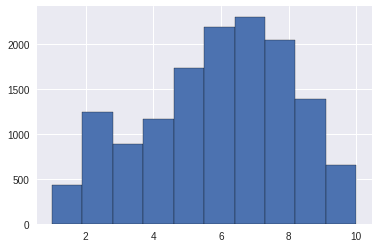

In [26]:
pd.Series(num_unique_sites).hist(edgecolor = 'black')
plt.show()

**Проверим с помощью QQ-плота и критерия Шапиро-Уилка, что эта величина распределена нормально**

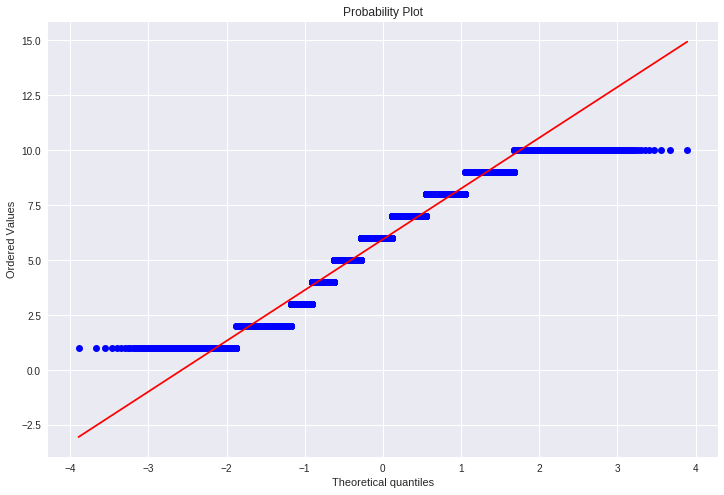

In [27]:
plt.figure(figsize=(12,8))
stats.probplot(num_unique_sites, dist="norm", plot=plt)
plt.show()

In [28]:
print ("Критерий Шапиро-Уилка, W-статистика: %f, p-value: %f" % stats.shapiro(num_unique_sites))

Критерий Шапиро-Уилка, W-статистика: 0.954693, p-value: 0.000000


**Проверим гипотезу о том, что пользователь хотя бы раз зайдет на сайт, который он уже ранее посетил в сессии из 10 сайтов. Проверим с помощью биномиального критерия для доли, что доля случаев, когда пользователь повторно посетил какой-то сайт (то есть число уникальных сайтов в сессии < 10) велика: больше 95%**

In [29]:
has_two_similar = (np.array(num_unique_sites) < 10).astype('int')
pi_val = stats.binom_test(sum(has_two_similar), len(has_two_similar), 0.95, alternative = 'greater')
print ('P-value = %s' % round(pi_val, 3))

P-value = 0.022


**Построим для этой доли 95% доверительный интервал Уилсона**

In [30]:
wilson_interval = proportion_confint(sum(has_two_similar), len(has_two_similar), method = 'wilson')
print ('Доверительный интервал Уилсона [%f, %f], его ширина = %f' % (wilson_interval[0],
                                                  wilson_interval[1],
                                                  wilson_interval[1] - wilson_interval[0]))

Доверительный интервал Уилсона [0.950103, 0.957053], его ширина = 0.006950


**Построим распределение частоты посещения сайтов (сколько раз тот или иной сайт попадается в выборке) для сайтов, которые были посещены как минимум 1000 раз**

In [31]:
a = {}
for j in xrange(len(user_path10)):
    data_sort = list(pd.read_csv(user_path10[j], squeeze = True, usecols=['site']))
    for i in xrange(len(data_sort)):
        a[data_sort[i]] = a.get(data_sort[i], 0) + 1
    
b = sorted(a.items(), key = lambda x: x[1], reverse = True)
b1 = {}
id = 1
for i in range(len(b)):
    b1[b[i][0]] = (id, b[i][1])
    id += 1
    
b2 = sorted(b1.items(), key = lambda x: x[1][1], reverse = True)
    
b3 = pd.DataFrame(data = b2, columns=(['site', 'freq']))

site_freqs1 = b3.freq[:25]

site_freqs = []
for i in range(len(site_freqs1)):
    site_freqs.append(site_freqs1[i][1])
    
site_freqs2 = []
for i in range(len(b3.freq)):
    site_freqs2.append(b3.freq[i][1])

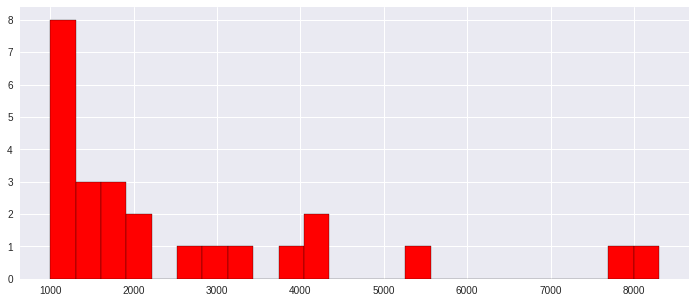

In [32]:
pylab.figure(figsize(12, 5))
pylab.hist(site_freqs, bins = 24, color = 'r', edgecolor = 'black')

pylab.show()

**Построим 95% доверительный интервал для средней частоты появления сайта в выборке (во всей, уже не только для тех сайтов, что были посещены как минимум 1000 раз) на основе bootstrap. Используем столько же bootstrap-подвыборок, сколько сайтов оказалось в исходной выборке по 10 пользователям**

In [33]:
# Подготовка бутстрап-выборки
def get_bootstrap_samples(data, n_samples, random_seed=17):
    np.random.seed(random_seed)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, 
                 [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [34]:
site_np = np.array(site_freqs)
site_np2 = np.array(site_freqs2)

np.random.seed(0)

over1000_score = map(np.mean, get_bootstrap_samples(site_np2, len(b3)))

print ("95% доверительный интервал для средней частоты появления сайта в выборке:",
       stat_intervals(over1000_score, 0.05))

95% доверительный интервал для средней частоты появления сайта в выборке: [ 22.51524527  35.76303684]


# <center>Часть 3. Визуальный анализ данных и построение признаков

## Часть 3.1. Подготовка новых признаков

**Для анализа исходных данных создадим на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, и добавим следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

In [35]:
feature_names = ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week']

In [36]:
def prepare_train_set_with_fe(path_to_csv_files, feature_names,
                                    session_length=10, window_size=10):
    
    # Создание словаря сайтов
    a = {}
    for j in xrange(len(path_to_csv_files)):
        data_sort = list(pd.read_csv(path_to_csv_files[j], squeeze = True, usecols=['site']))
        for i in xrange(len(data_sort)):
            a[data_sort[i]] = a.get(data_sort[i], 0) + 1
    
    # Упорядочиваем индексы в словаре сайтов по популярности сайта
    b = sorted(a.items(), key = lambda x: x[1], reverse = True)
    b1 = {}
    id = 1
    for i in range(len(b)):
        b1[b[i][0]] = (id, b[i][1])
        id += 1
    
    b2 = sorted(b1.items(), key = lambda x: x[1][1], reverse = True)
    
    b4 = dict(b2)
    
    b3 = pd.DataFrame(data = b2, columns=(['site', 'freq']))       
        
    df_list = list(["site%s" % k for k in range(1, session_length + 1)] + feature_names)
    df_list.append('user_id')
    dataframe_list = []

    for i in range(len(path_to_csv_files)):
        session_start = 0
        data = list(pd.read_csv(path_to_csv_files[i], squeeze = True, usecols=['site']))
        datastamp = list(pd.to_datetime(pd.read_csv(path_to_csv_files[i], squeeze = True, usecols = ['timestamp'])))
        if ((len(data) - window_size) % window_size) != 0:
            n = ((len(data) - window_size) // window_size) + 2
        else:
            n = ((len(data) - window_size) // window_size) + 1
        for j in range(n):
            new_line = []
            new_line = list(b4[data[window_size * j + k]][0] if (
                j * window_size + k) < len(data) else 0 for k in range(session_length))
            if new_line.count(0) != 0:
                k1 = new_line.index(0)
            else:
                k1 = session_length
            session_end = session_length * j + k1 - 1
            if new_line.count(0) == 0:
                unique = len(pd.Series(new_line).unique())
            else:
                unique = len(pd.Series(new_line).unique()) - 1
            # Добавляем время начала сессии
            new_line.append((datastamp[session_end] - datastamp[session_start]).seconds)
            # Добавляем количество уникальных сайтов в сессии
            new_line.append(unique)
            # Добавляем час начала сессии
            new_line.append(datastamp[session_start].hour)
            # Добавляем день недели начала сессии
            new_line.append(datastamp[session_start].dayofweek)
            new_line.append(i + 1)
            session_start = session_end + 1
            dataframe_list.append(new_line)
    c = pd.DataFrame(data = dataframe_list, columns=df_list)    
    
    return c

**Применим функцию *prepare_train_set_with_fe* к данным по 10 пользователям при *session_length*=10**

In [37]:
%%time
train_data_10users = prepare_train_set_with_fe(user_path10,
                  feature_names=feature_names, session_length=10)

CPU times: user 3.13 s, sys: 8 ms, total: 3.14 s
Wall time: 3.13 s


In [38]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,192,586,134,3,134,134,3,134,204,134,33,5,8,4,1
1,416,193,683,256,134,31,393,3515,217,55,284,10,8,4,1
2,55,3,55,55,5,293,416,337,918,55,258,7,8,4,1
3,483,3734,483,55,55,55,55,982,201,123,30,6,8,4,1
4,349,55,5,4459,259,212,4217,2422,684,2422,6,9,8,4,1


**Применим функцию *prepare_train_set_with_fe* к данным по 150 пользователям при *session_length*=10**

In [39]:
%%time
train_data_150users = prepare_train_set_with_fe(user_path150,
                  feature_names=feature_names, session_length=10)

CPU times: user 30 s, sys: 88 ms, total: 30.1 s
Wall time: 30.1 s


## Часть 3.2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [40]:
id_name_dict = {1: 'Mary-Kate', 2: 'Ashley', 3: 'Lindsey', 4: 'Naomi', 5: 'Avril',
               6: 'Bob', 7: 'Bill', 8: 'John', 9: 'Dick', 10: 'Ed'}
train_data_10users['user_id'] = train_data_10users['user_id'].map(id_name_dict)

In [41]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**Построим гистограмму распределения длины сессии в секундах (*session_timespan*). Тяжелый хвост опустим**

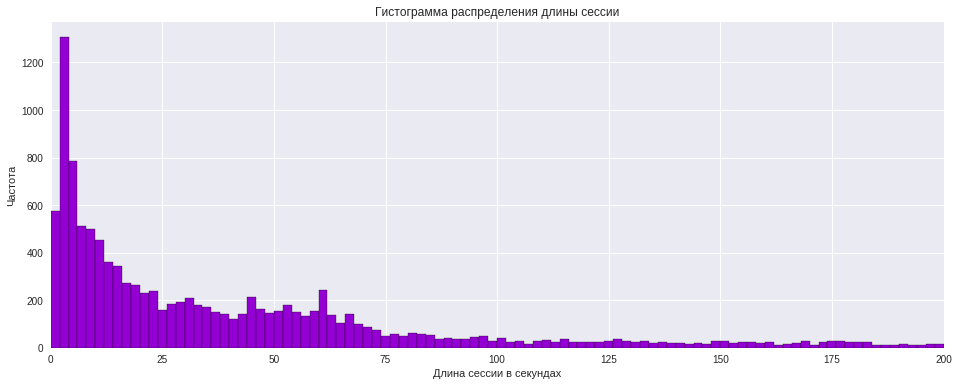

In [42]:
train_data_10users.session_timespan.plot.hist(figsize = (16, 6), bins = 100, range = (0, 200),
                        title = u'Гистограмма распределения длины сессии', color = 'darkviolet'
                                             , edgecolor = 'black')
plt.xlim([0, 200])
plt.ylabel(u'Частота')
plt.xlabel(u'Длина сессии в секундах')
plt.show()

**Построим гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*)**

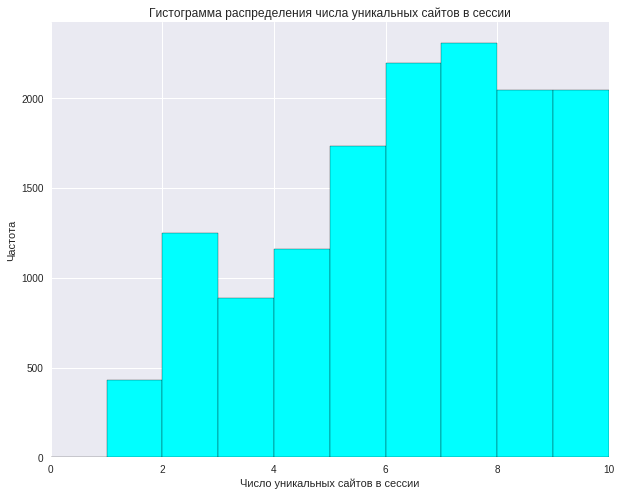

In [43]:
train_data_10users['#unique_sites'].plot.hist(figsize = (10, 8), range = (0, 10), edgecolor = 'black',
                        title = u'Гистограмма распределения числа уникальных сайтов в сессии', color = 'aqua')
plt.xlim([0, 10])
plt.ylabel(u'Частота')
plt.xlabel(u'Число уникальных сайтов в сессии')
plt.show()

**Построим гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности**

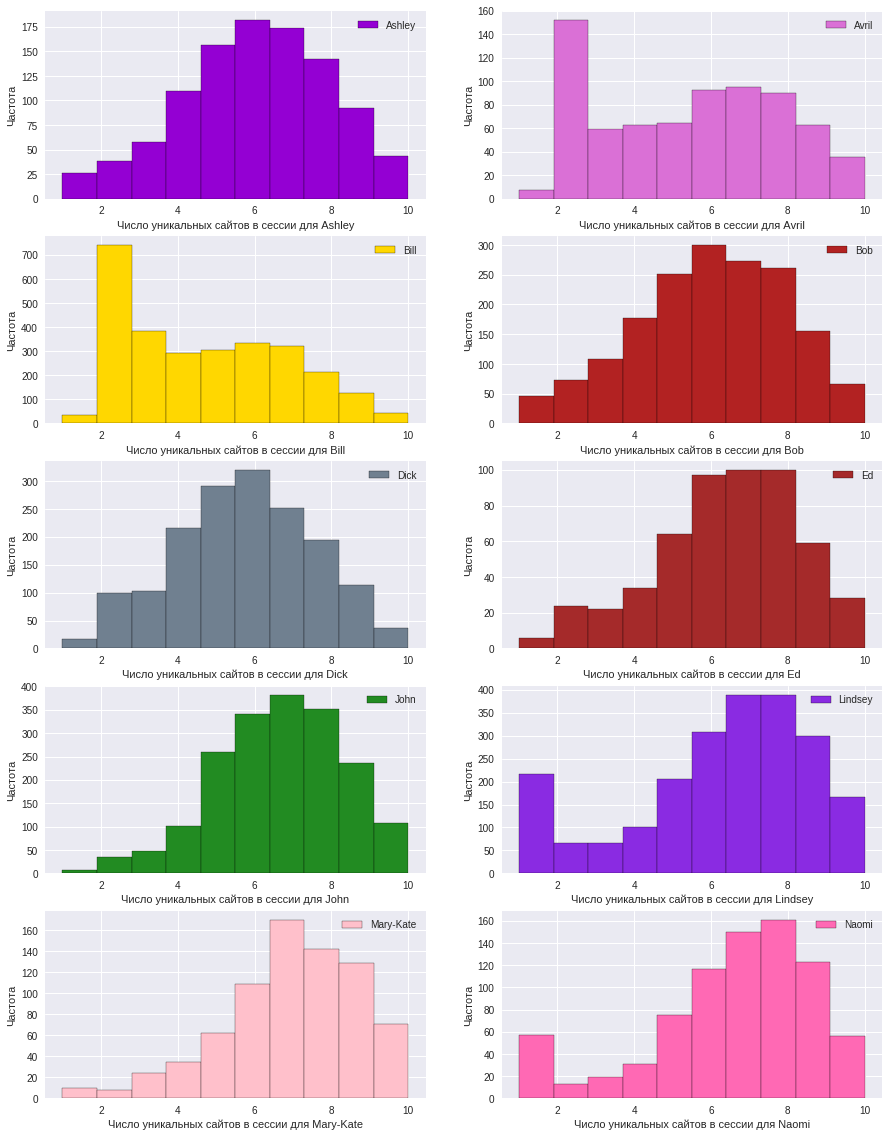

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 20))

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    plt.subplot(5, 2, idx + 1)
    sub_df['#unique_sites'].plot.hist(color = color_dic[user], label = user, edgecolor = 'black')
    xlim = ([0, 10])
    plt.legend()
    plt.ylabel(u'Частота')
    plt.xlabel(u'Число уникальных сайтов в сессии для %s' % user)
plt.show()

**Построим гистограмму распределения часа начала сессии (*start_hour*)**

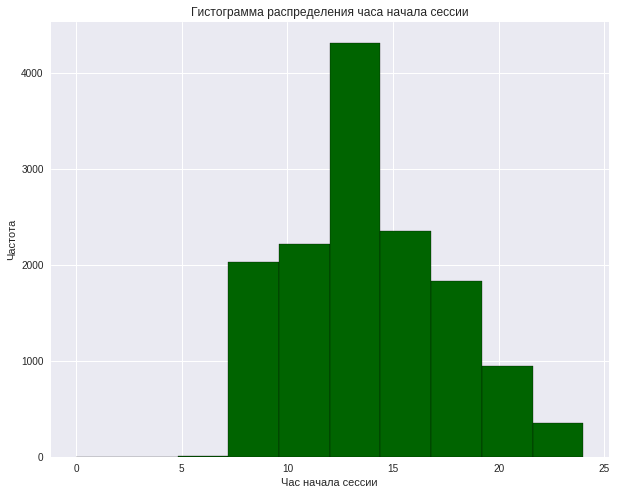

In [45]:
train_data_10users['start_hour'].plot.hist(figsize = (10, 8), range = (0, 24), edgecolor = 'black',
                        title = u'Гистограмма распределения часа начала сессии', color = 'darkgreen')
plt.ylabel(u'Частота')
plt.xlabel(u'Час начала сессии')
plt.show()

**Построим гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности**

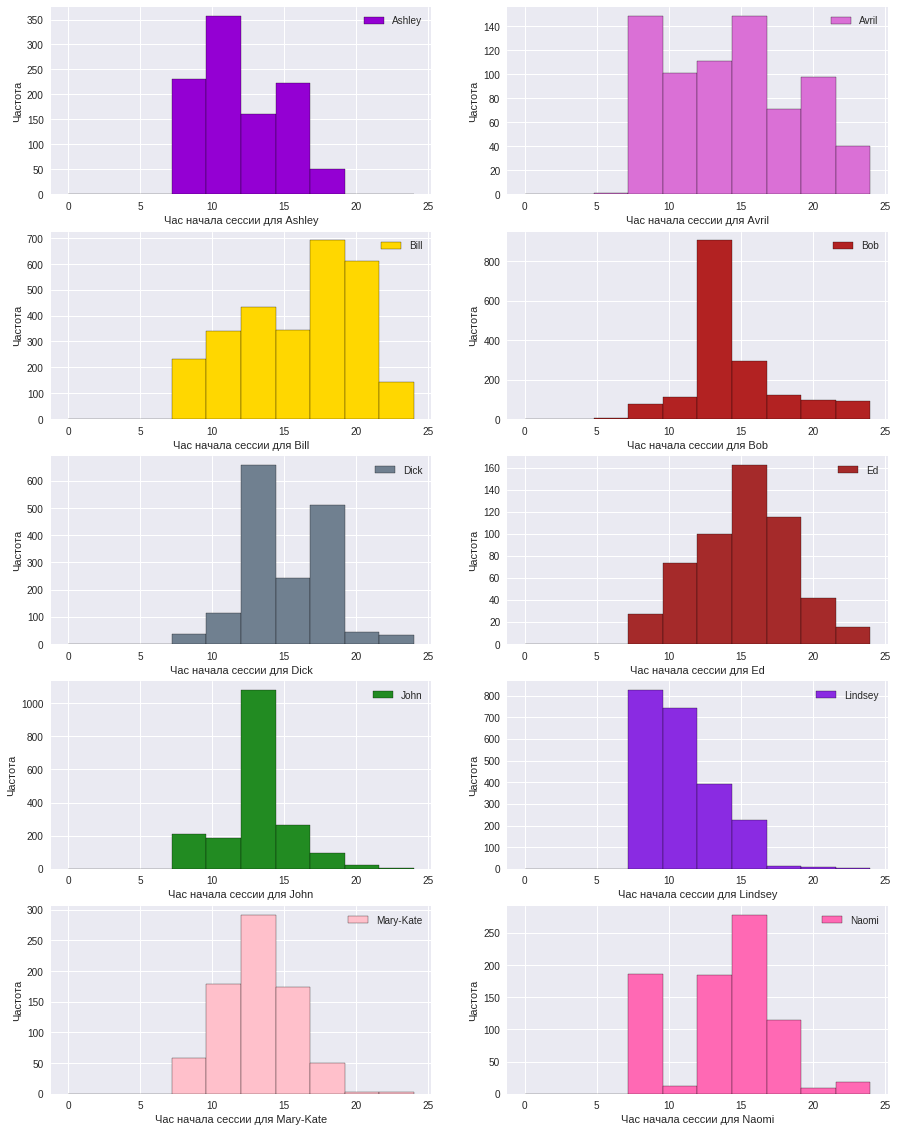

In [46]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 20))

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    plt.subplot(5, 2, idx + 1)
    sub_df['start_hour'].plot.hist(color = color_dic[user], label = user, range = (0, 24), edgecolor = 'black')
    plt.legend()
    plt.ylabel(u'Частота')
    plt.xlabel(u'Час начала сессии для %s' % user)
plt.show()

**Построим гистограмму распределения дня недели, в который началась сессия (*day_of_week*)**

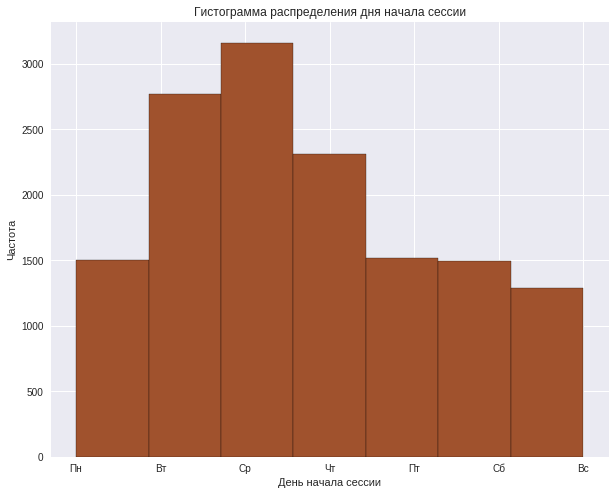

In [47]:
ax = train_data_10users['day_of_week'].plot.hist(figsize = (10, 8), bins = 7, edgecolor = 'black',
                        title = u'Гистограмма распределения дня начала сессии', color = 'sienna')
days = [0, u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс']
ax.set_xticklabels(days)
plt.ylabel(u'Частота')
plt.xlabel(u'День начала сессии')
plt.show()

**Построим гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой**

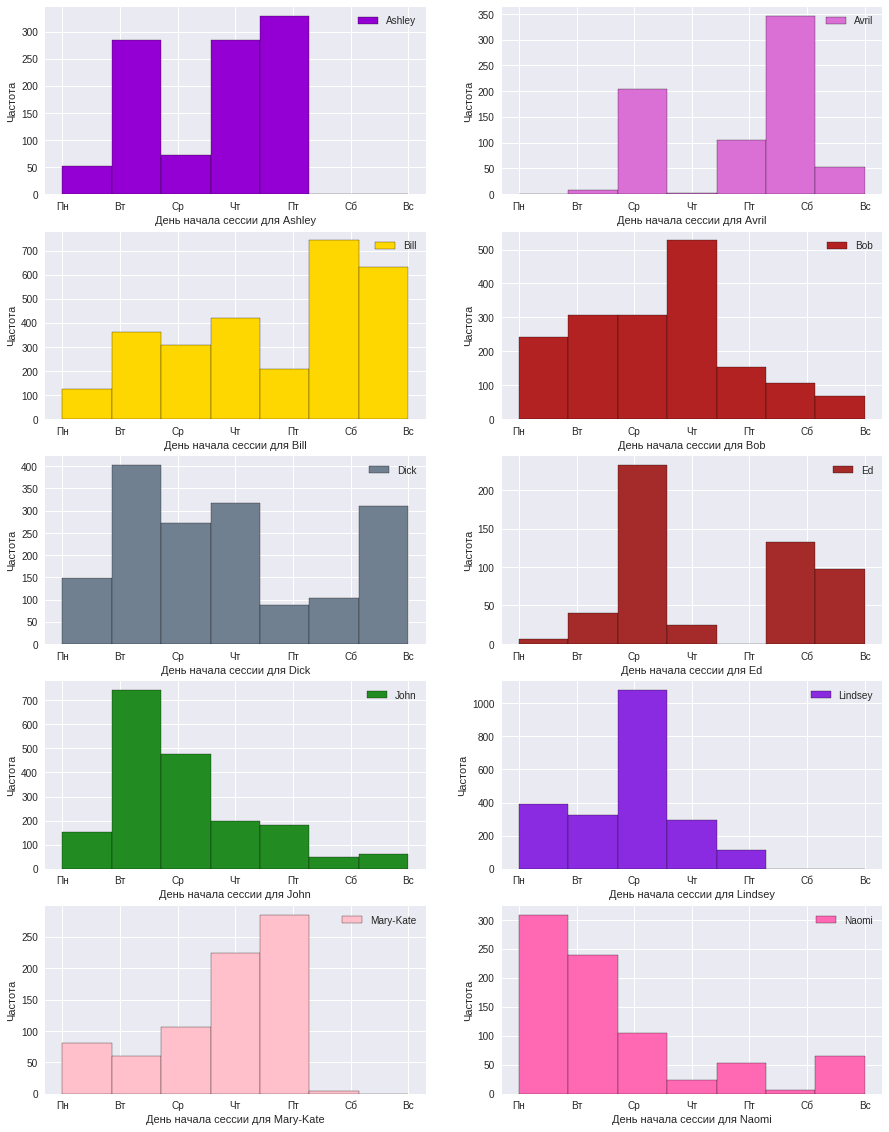

In [48]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 20))

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    ax = plt.subplot(5, 2, idx + 1)
    sub_df['day_of_week'].plot.hist(color = color_dic[user], label = user, edgecolor = 'black',
                                    bins = 7, range = (0, 6))
    plt.legend()
    plt.ylabel(u'Частота')
    plt.xlabel(u'День начала сессии для %s' % user)
    ax.set_xticklabels(days)
plt.show()

** Некоторые выводы по построенным графикам **

1. По графику распределения длины сессии видно, что продолжительно большого количества сессий (более трети) укладывается в 25 секунд. Можно предположить, что это свидетельствует либо об открытии большого количества рекламных сайтов при клике на какую-то ссылку, либо о неполных сессиях с малым количеством сайтов. Следующая выделяющаяся область на графике - до 75-100 секунд. Предположу, что эти сессии указывают на быструю рутинную "проверку" соцсетей, почты и других сервисов на наличие обновлений. Дальнейший длинный хвост распределения похож на вдумчивое изучение сайтов в сессии.

2. Гистограмма распределения числа уникальных сайтов в сессии имеет максимум на значениях 7-8 при длине сессии в 10 сайтов. Это говорит о том, что чаще всего посещение сайтов пользователями носит характер сёрфинга, а не детальное изучение малого количества ресурсов.

3. Более детальный анализ уникальности сайтов в сессии по пользователям в целом потверждает предыдущую идею. Среди пользователей можно выделить как сёрферов (Эшли, Боб, Эд, Джон), так и вдумчивых пользователей, которые более внимательно изучают определенный ресурс (Билл, Дик, Аврил).

4. Гистограмма часа начала сессии предсказуемо указывает на диапазон с 7 утра до 11 вечера с максимумом в районе обеда (12-15 часов). К вечеру активность падает, что объяснимо: если человек не зашел в интернет к 15-16 часам, вероятность того, что он зайдет в него только вечером, уменьшается.

5. Гистограммы отдельных пользователей описывают их поведение в интернете в течение дня. Некоторые, как Эшли или Джон активно используют интернет на работе. Причем, если Джон и Мэри активнее всего включаются в обеденное время (либо поздно просыпаются, либо в обеденный перерыв на работе сёрфят в интернете), то Линдси чаще всего начинает работу с раннего утра. Другие, как например, Билл, больше пользуются интернетом вечером, что может означать, что его работа меньше связана с сетью, а вечером он отдыхает, сидя за компьютером. Или же его график работы подразумевает вечернюю работу.

6. Общая гистограмма дней недели начала сессии указывает на то, что самые активные дни для начала работы в интернете это вторник и среда.

7. Для отдельных пользователей картина более детальная. Эшли и Линдси почти не заходят в интернет в выходные, что может говорить о том, что сеть им нужна только для работы, а сами они не активные пользователи. Упомянутый ранее Билл, который активничает по вечерам имеет пики выходов в интернет в выходные, что подтверждает гипотезу о том, что Билл чаще использует интернет для личных целей в свободное от работы время.

**Определим топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*)**

In [49]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as fin:
    freqs10 = dict(pickle.load(fin))   
    
freqs10_sorted = sorted(freqs10.items(), key = lambda x: x[1][1], reverse = True)

top10_freqs = list(freqs10_sorted[i][1][1] for i in range(10))
top10_sites = list(freqs10_sorted[i][0] for i in range(10))

**Нарисуем график частот посещений топ-10 сайтов**

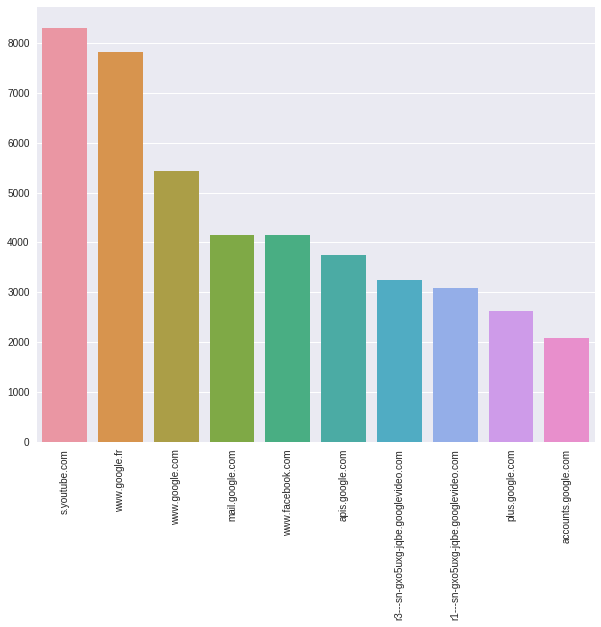

In [50]:
fig = plt.figure(figsize = (10, 8))
ax = sns.barplot(top10_sites, top10_freqs)
ax.set_xticklabels(top10_sites, rotation = 90)
plt.show()

## Часть 3.3. Проверка построенных признаков

In [51]:
print ('Медианное значение продолжительности сессии для 10 пользователей = %s' % 
    np.median(train_data_10users.session_timespan))

Медианное значение продолжительности сессии для 10 пользователей = 37.0


In [52]:
print ('Медианный день недели начала сессии для 10 пользователей = %s' % 
       np.median(train_data_10users.day_of_week))

Медианный день недели начала сессии для 10 пользователей = 2.0


In [53]:
print ('Медианный час начала сессии для 10 пользователей = %s' % np.median(train_data_10users.start_hour))

Медианный час начала сессии для 10 пользователей = 14.0


In [54]:
print ('Медианное значение числа уникальных сайтов для 150 пользователей = %s' %
        np.median(train_data_150users['#unique_sites']))

Медианное значение числа уникальных сайтов для 150 пользователей = 7.0


# <center>Часть 4. Обучение модели и сравнение алгоритмов классификации</center>

Сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

## Часть 4.1. Сравнение алгоритмов классификации

**Разобьем обучающую выборку для 10 пользователей на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [55]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

In [56]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state = 17 – для воспроизводимости.**

In [57]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [58]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**Обучим `KNeighborsClassifier` со 100 ближайшими соседями и посмотрим на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используем для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [59]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=100, p=2,
           weights='uniform')

In [60]:
print ('Доля правильных ответов KNeighbors классификатора на кросс-валидации = %s' % 
       round(np.mean(cross_val_score(knn, X_train, y_train, cv = skf)), 3))
print ('Доля правильных ответов KNeighbors классификатора на отложенной выборке = %s' %
      round(accuracy_score(y_valid, knn.predict(X_valid)), 3))

Доля правильных ответов KNeighbors классификатора на кросс-валидации = 0.562
Доля правильных ответов KNeighbors классификатора на отложенной выборке = 0.584


**Обучим случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрим на OOB-оценку и на долю правильных ответов на выборке `(X_valid, y_valid)`**

In [61]:
forest = RandomForestClassifier(n_estimators=100, random_state=17, oob_score=True, n_jobs=-1)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=17,
            verbose=0, warm_start=False)

In [62]:
print ('Доля правильных ответов RandomForest классификатора на Out-of-Bag выборке = %s' % 
       round(forest.oob_score_, 3))
print ('Доля правильных ответов RandomForest классификатора на отложенной выборке = %s' %
      round(accuracy_score(y_valid, forest.predict(X_valid)), 3))

Доля правильных ответов RandomForest классификатора на Out-of-Bag выборке = 0.723
Доля правильных ответов RandomForest классификатора на отложенной выборке = 0.735


**Обучим логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрим на долю правильных ответов на кросс-валидации (используем объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`**

In [63]:
logit = LogisticRegression(random_state=17)
logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [64]:
print ('Доля правильных ответов LogisticRegression классификатора на кросс-валидации = %s' % 
       round(np.mean(cross_val_score(logit, X_train, y_train, cv = skf)), 3))
print ('Доля правильных ответов LogisticRegression классификатора на отложенной выборке = %s' %
      round(accuracy_score(y_valid, logit.predict(X_valid)), 3))

Доля правильных ответов LogisticRegression классификатора на кросс-валидации = 0.763
Доля правильных ответов LogisticRegression классификатора на отложенной выборке = 0.782


**С помощью `LogisticRegressionCV` подберем параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2**

In [65]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(multi_class='multinomial', random_state=17, Cs=logit_c_values1, 
                                            cv = skf, tol = 1e-4)
logit_grid_searcher1.fit(X_train, y_train)

CPU times: user 48.3 s, sys: 112 ms, total: 48.4 s
Wall time: 24.2 s


In [66]:
logit_mean_cv_scores1 = logit_grid_searcher1.scores_[1].mean(axis = 0)
maxnumber = max(itertools.izip(logit_mean_cv_scores1, itertools.count()))[1]
print ('Максимальное С = %s при доле правильных ответов = %s' % (round(logit_grid_searcher1.Cs[maxnumber], 3), 
                                                                round(logit_mean_cv_scores1[maxnumber], 4)))

Максимальное С = 4.642 при доле правильных ответов = 0.7623


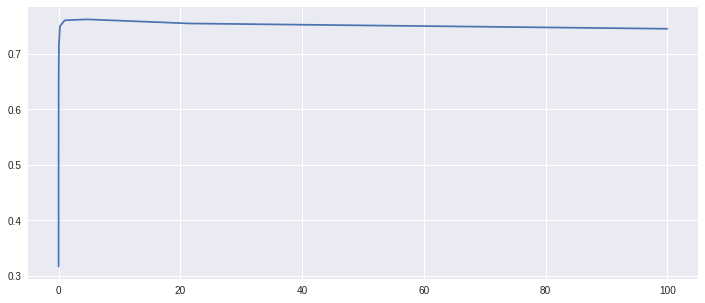

In [67]:
# График зависимости доли правильных ответов на кросс-валидации от `C`
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра `C` перебираем в диапазоне `np.linspace`(3, 7, 20)**

In [68]:
%%time
logit_c_values2 = np.linspace(3, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(multi_class='multinomial', random_state=17, Cs=logit_c_values2, 
                                            cv = skf, tol = 1e-4)
logit_grid_searcher2.fit(X_train, y_train)

CPU times: user 2min 20s, sys: 544 ms, total: 2min 21s
Wall time: 1min 10s


In [69]:
logit_mean_cv_scores2 = logit_grid_searcher2.scores_[1].mean(axis = 0)
maxnumber2 = max(itertools.izip(logit_mean_cv_scores2, itertools.count()))[1]
print ('Уточненное максимальное С = %s при доле правильных ответов = %s' % (
    round(logit_grid_searcher2.Cs[maxnumber2], 3), round(logit_mean_cv_scores2[maxnumber2], 4)))

Уточненное максимальное С = 3.421 при доле правильных ответов = 0.7633


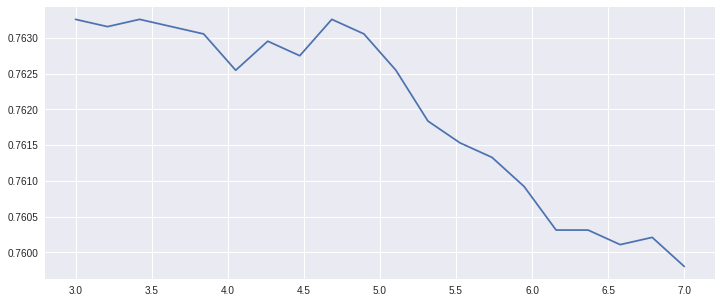

In [70]:
# График зависимости доли правильных ответов на кросс-валидации от `C`
plt.plot(logit_c_values2, logit_mean_cv_scores2);

** Выведем долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.**

In [71]:
log2 = LogisticRegression(C = logit_grid_searcher2.Cs[maxnumber2], random_state=17)
log2.fit(X_train, y_train)
print ('Доля правильных ответов на кросс-валидации для логистической регрессии с лучшим значение С = %s'
      % round(np.mean(cross_val_score(log2, X_train, y_train, cv = skf)), 3))
print ('Доля правильных ответов на отложенной выборке для логистической регрессии с лучшим значением С = %s'
       % round(accuracy_score(y_valid, logit.predict(X_valid)), 3))

Доля правильных ответов на кросс-валидации для логистической регрессии с лучшим значение С = 0.766
Доля правильных ответов на отложенной выборке для логистической регрессии с лучшим значением С = 0.782


**Обучим линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости)**

In [72]:
svm = LinearSVC(C = 1, random_state = 17)
svm.fit(X_train, y_train)
print ('Доля правильных ответов SVM классификатора на кросс-валидации = %s'
       % round(cross_val_score(svm, X_valid, y_valid, cv = skf).mean(), 3))

Доля правильных ответов SVM классификатора на кросс-валидации = 0.708


**С помощью `GridSearchCV` подберем параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4**

In [73]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, param_grid=svm_params1)
svm_grid_searcher1.fit(X_train, y_train)

CPU times: user 58.9 s, sys: 0 ns, total: 58.9 s
Wall time: 58.9 s


In [74]:
svm_score1 = svm_grid_searcher1.best_score_
print ('Лучшее значение доли правильных ответов на кросс-валидации = %s' % round(svm_score1, 3))
svm_param1 = svm_grid_searcher1.best_params_['C']
print ('При С = %s' % round(svm_param1, 3))

Лучшее значение доли правильных ответов на кросс-валидации = 0.685
При С = 7777.778


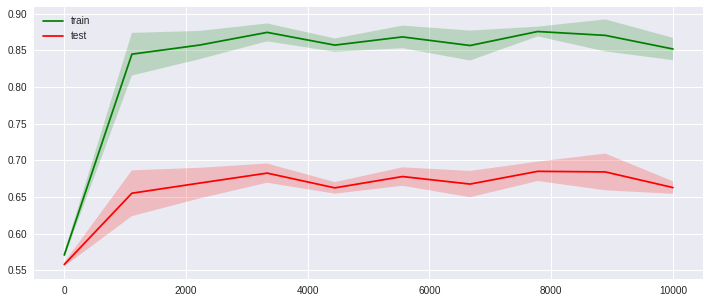

In [75]:
# График зависимости доли правильных ответов на кросс-валидации от C
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай, когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберем параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений**

In [76]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, param_grid=svm_params2)
svm_grid_searcher2.fit(X_train, y_train)

CPU times: user 1min 45s, sys: 504 ms, total: 1min 46s
Wall time: 1min 46s


In [77]:
svm_score2 = svm_grid_searcher2.best_score_
print ('Лучшее значение доли правильных ответов на кросс-валидации = %s' % round(svm_score2, 3))
svm_param2 = svm_grid_searcher2.best_params_['C']
print ('При С = %s' % round(svm_param2, 3))

Лучшее значение доли правильных ответов на кросс-валидации = 0.766
При С = 0.139


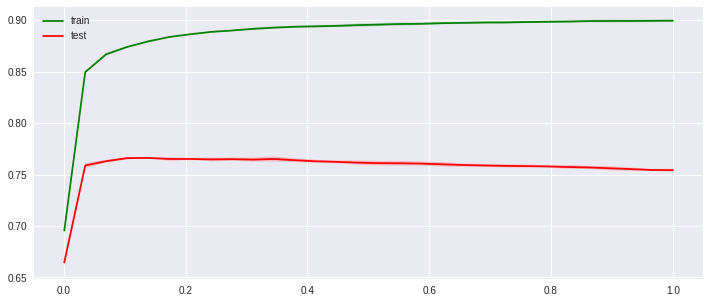

In [78]:
# График зависимости доли правильных ответов на кросс-валидации от C
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

In [79]:
print ('Доля правильных ответов на отложенной выборке для нового лучшего С = %s'
       % round(accuracy_score(y_valid, svm.predict(X_valid)), 3))

Доля правильных ответов на отложенной выборке для нового лучшего С = 0.777


## Часть 4.2. Выбор параметров - длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`**

In [80]:
# Определим функцию, которая вычисляет долю правильных ответов на кросс-валидации для (1 - тестовая_выборка) 
# обучающей выборки, а также долю правильных ответов на отложенной выборке

def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    
    with open(os.path.join(path_to_X_pickle), 'rb') as X_sparse_pkl:
        X_sparse = pickle.load(X_sparse_pkl)
    with open(os.path.join(path_to_y_pickle), 'rb') as y_pkl:
        y = pickle.load(y_pkl)
        
    X_train, X_test, y_train, y_test = train_test_split(X_sparse, y, test_size = test_size, 
                                                        random_state = random_state, stratify = y)
    
    train_acc = cross_val_score(estimator, X_train, y_train, cv = cv).mean()
    test_acc = accuracy_score(y_test, estimator.predict(X_test))
    
    return train_acc, test_acc

**Применим функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей**

In [81]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_10users_s%s_w%s.pkl' % (session_length, window_size))
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_10users_s%s_w%s.pkl' % (session_length, window_size))
        print ('For session length %s and window size %s' % (session_length, window_size))
        print (model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3))

For session length 15 and window size 10
(0.82595319827253111, 0.83076558426167335)
For session length 10 and window size 10
(0.76417363642629177, 0.78170182507703245)
For session length 15 and window size 7
(0.85049518520747569, 0.86344781815165095)
For session length 10 and window size 7
(0.80013853854774963, 0.83242077318732366)
For session length 7 and window size 7
(0.75120696889755278, 0.79757756761241083)
For session length 15 and window size 5
(0.87069486530504658, 0.86913229018492177)
For session length 10 and window size 5
(0.81643144923195299, 0.83985301090564246)
For session length 7 and window size 5
(0.77309267746369503, 0.80275011853959222)
For session length 5 and window size 5
(0.72309700526189014, 0.76078710289236606)
CPU times: user 25.6 s, sys: 28 ms, total: 25.7 s
Wall time: 25.7 s


## Часть 4.3. Идентификация конечного пользователя

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо**

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [82]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [83]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучим `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части). Теперь будем решать 150 задач "Один-против-Всех"**

In [84]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs = [0.13879310344827586], 
                                         multi_class = 'ovr', n_jobs = -1, random_state = 17)
logit_cv_150users.fit(X_train_150, y_train_150)

CPU times: user 3min 34s, sys: 964 ms, total: 3min 35s
Wall time: 5min 12s


**Посмотрим на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [85]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format(user_id, logit_cv_150users.scores_[user_id].mean()))

User 1, CV score: 0.995391318841
User 2, CV score: 0.995996421663
User 3, CV score: 0.994880887618
User 4, CV score: 0.991210928449
User 5, CV score: 0.989458954529
User 6, CV score: 0.994578470355
User 7, CV score: 0.993337781052
User 8, CV score: 0.985528453269
User 9, CV score: 0.997768712011
User 10, CV score: 0.99442210693
User 11, CV score: 0.994192777373
User 12, CV score: 0.99339009849
User 13, CV score: 0.996934749889
User 14, CV score: 0.994974647742
User 15, CV score: 0.99636128288
User 16, CV score: 0.996277889477
User 17, CV score: 0.990355876892
User 18, CV score: 0.994213604299
User 19, CV score: 0.994734801323
User 20, CV score: 0.990866843289
User 21, CV score: 0.97874141854
User 22, CV score: 0.996507289738
User 23, CV score: 0.993692120565
User 24, CV score: 0.990136885965
User 25, CV score: 0.996288264931
User 26, CV score: 0.994046747263
User 27, CV score: 0.994839055058
User 28, CV score: 0.990188375257
User 29, CV score: 0.983996208357
User 30, CV score: 0.997257

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитаем для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [86]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = {}

for user_id in np.unique(y_train_150):
    acc_diff_vs_constant[user_id] = logit_cv_150users.scores_[user_id].mean(axis = 0) - (1 - class_distr[user_id] / len(y_train_150))

In [87]:
print ('Доля пользователей, для которых модель дает прогноз лучше константного = %s'
      % round((np.array(list(acc_diff_vs_constant.values())) > 0).sum() / 150, 3))

Доля пользователей, для которых модель дает прогноз лучше константного = 0.873


**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составим новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID пользователя 128.**

In [88]:
y_binary_128 = []
for i in range(len(y_150users)):
    if y_150users[i] == 128:
        y_binary_128.append(1)
    else:
        y_binary_128.append(0)

In [89]:
def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитаем доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки**

In [90]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_sparse_150users, y_150users)

CPU times: user 12min 10s, sys: 412 ms, total: 12min 10s
Wall time: 12min 10s


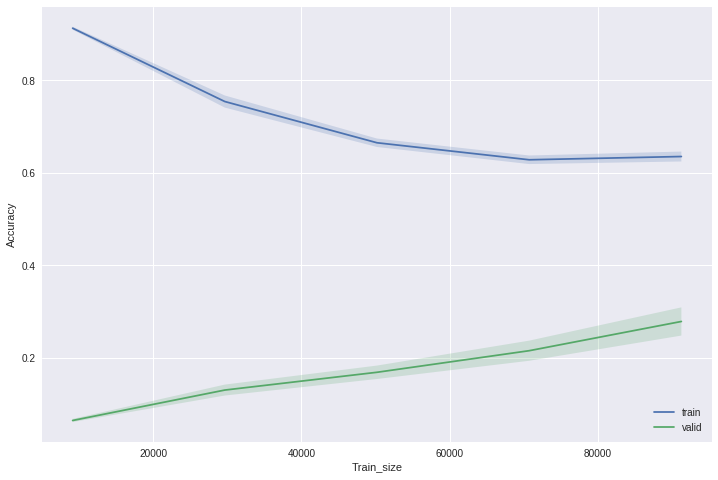

In [91]:
fig = plt.figure(figsize = (12, 8))

plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='Train_size', ylabel='Accuracy')

** В проекте были исследованы несколько методов построения модели для решения задачи идентафикации интернет-пользователей по их поведению: метод k ближайших соседей, случайный лес, логистическая регрессия и метод опорных векторов. Из них лучшими для конкретной задачи себя показали последние два, для которых был осуществлен более детальный подбор параметров. В итоге немного лучше себя показал метод опорных векторов, который и был выбран в качестве финального. **

** Полученная модель позволяет хорошо решить задачу идентификации интернет-пользователей. Достигаемый уровень точности по доле правильных ответов для каждого пользователя в среднем составляет около 0.99, при этом, учитывая дисбаланс классов, доля пользователей, для которых прогноз модели лучше константного составляет 0.87.**

** Хорошим способо дальнейшей проверки работоспособности модели был бы анализ выборки из 3000 пользователей. Но вычислительные способности рабочей техники не позволяют произвести этот анализ за разумное время.**

** Дальнейшими шагами по улучшению модели могли бы быть более детальная работа с дисбалансом классов, а также углубленный подбор параметров модели.**